# Schrodinger's Equation

## References -- move to bottom
* Atkins & Friedman (Molecular Quantum Mechanics textbook)
* Barba, Lorena A., et al. "MAE 6286 Practical Numerical Methods with Python." The George Washington University. http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about. 2014
* http://arxiv.org/pdf/0704.3240.pdf
* http://phys.au.dk/fileadmin/site_files/publikationer/phd/Thomas_Kim_Kjeldsen.pdf
* https://en.wikipedia.org/wiki/Wave_packet

Wave functions are used in quantum mechanics to describe the position of a particle at a certain time. The fundamental equation used to solve these wave functions is the Schrodinger equation. 

\begin{equation}
i\hbar\frac{\partial}{\partial t}\psi(x, t) = -\frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2}\psi(x, t)
\end{equation}

Discretized Equation:

\begin{eqnarray}
i\hbar\frac{\psi^{n+1}_i - \psi^n_i}{\Delta t} = \frac{\hbar^2}{2m} \cdot \frac{1}{2} &\left( 
\frac{\psi^{n+1}_{i+1} - 2\psi^{n+1}_i + \psi^{n+1}_{i-1}}{\Delta x^2} 
+ \frac{\psi^n_{i+1}-2\psi^n_i + \psi^n_{i-1}}{\Delta x^2}
\right)
\end{eqnarray}

In [72]:
import numpy
from scipy.linalg import solve
from scipy.interpolate import spline
from matplotlib import pyplot
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [107]:
L = 100
nx = 51

h = 6.62607004e-34 #[m^2*kg/s]
#hbar = h/(2*numpy.pi)
hbar=1
m = 9.10938356e-31 #[kg] - mass of electron
dx = L/(nx-1)

a = hbar/(2*m)
#print(a)


psi_i = numpy.zeros(nx, dtype = numpy.complex)
psi_i[0] = 1

sigma = 9 #0.5
dt = (dx**2)/(a*sigma)
#dt=1e-5

nt = 10

print(dt)

8.097229831111111e-31


In [108]:
def generateMatrix(N, sigma):
   
    ##We need a TRIDIAGONAL MATRIX!!

    # Set Diagonalfrom discritization
    #d = 2*numpy.diag(numpy.ones(N-2)*(1+1/sigma))
    d = -2*numpy.diag(numpy.ones(N-2)*(1/(dx**2)))
       
    # Set Upper Diagonal
    #ud = numpy.diag(numpy.ones(N-3)*-1j, 1)
    ud = numpy.diag(numpy.ones(N-3)*(-1/(dx**2)), 1)
        
    # Set Lower Diagonal
    #ld = numpy.diag(numpy.ones(N-3)*-1j, -1)
    ld = numpy.diag(numpy.ones(N-3)*(-1/(dx**2)), -1)
        
    A = d + ud + ld
    
    return A                   

In [109]:
#This is what we know

def genRHS(psi, sigma): 
    
    x = psi[1:-1]*2*(-1-1j/sigma) + psi[:-2] + psi[2:]
    
    #Dirichlet boundary conditions
    x[0] = psi[0]
    x[-1] = psi[0]
    
    return x

In [110]:
def CrankNicolson(psi, A, nt, sigma):
    
    for t in range(nt):
        psi_n = psi.copy()
        x = genRHS(psi_n, sigma)
        
        psi_inside = solve(A, x)
        psi[1:-1] = psi_inside
        
    return psi

In [111]:
A = generateMatrix(nx, sigma)

#print(A)

In [112]:
psi = CrankNicolson(psi_i.copy(), A, nt, sigma)

print(psi)

[  1.00000000e+00 +0.00000000e+00j  -8.26852510e+31 -4.51615581e+31j
   1.65370502e+32 +9.03231162e+31j  -2.47402906e+32 -1.35128098e+32j
   3.28458617e+32 +1.79399624e+32j  -4.08217644e+32 -2.22962918e+32j
   4.86365116e+32 +2.65646003e+32j  -5.62592524e+32 -3.07280375e+32j
   6.36598938e+32 +3.47701671e+32j  -7.08092198e+32 -3.86750316e+32j
   7.76790062e+32 +4.24272154e+32j  -8.42421327e+32 -4.60119057e+32j
   9.04726895e+32 +4.94149510e+32j  -9.63460797e+32 -5.26229167e+32j
   1.01839116e+33 +5.56231385e+32j  -1.06930114e+33 -5.84037723e+32j
   1.11598975e+33 +6.09538405e+32j  -1.15827267e+33 -6.32632762e+32j
   1.19598299e+33 +6.53229621e+32j  -1.22897182e+33 -6.71247671e+32j
   1.25710893e+33 +6.86615781e+32j  -1.28028326e+33 -6.99273280e+32j
   1.29840330e+33 +7.09170199e+32j  -1.31139752e+33 -7.16267468e+32j
   1.31921463e+33 +7.20537068e+32j  -1.32182377e+33 -7.21962143e+32j
   1.31921463e+33 +7.20537068e+32j  -1.31139752e+33 -7.16267468e+32j
   1.29840330e+33 +7.09170199e+32j

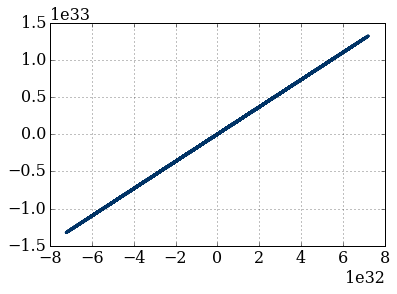

In [113]:
x = numpy.linspace(0,L,nx)

pyplot.plot(psi.imag, psi.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)

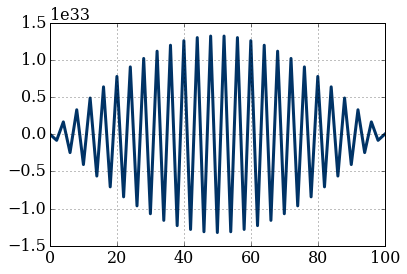

In [114]:
pyplot.plot(x, psi.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)

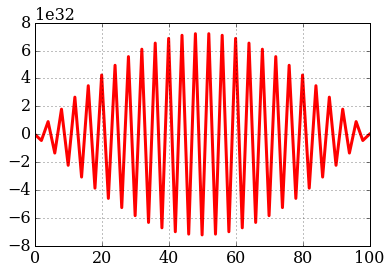

In [115]:
pyplot.plot(x, psi.imag, color='r', ls='-', lw=3);
pyplot.grid(True)

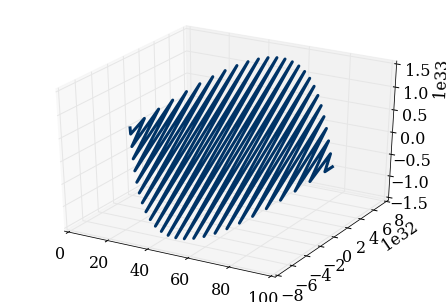

In [116]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.view_init()

ax.plot(x, psi.imag, psi.real, color = '#003366', lw =3)

In [102]:
"""
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

fig = pyplot.figure();
ax = pyplot.axes(xlim = (0,L), ylim = (-5,5))
line, = ax.plot([],[],lw = 2)

def animate(data):
    x = numpy.linspace(0, L, nx)
    y = data
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames = psi.imag, interval = 50)

display_animation(anim, default_mode = 'once')
"""

"\nfrom matplotlib import animation\nfrom JSAnimation.IPython_display import display_animation\n\nfig = pyplot.figure();\nax = pyplot.axes(xlim = (0,L), ylim = (-5,5))\nline, = ax.plot([],[],lw = 2)\n\ndef animate(data):\n    x = numpy.linspace(0, L, nx)\n    y = data\n    line.set_data(x, y)\n    return line,\n\nanim = animation.FuncAnimation(fig, animate, frames = psi.imag, interval = 50)\n\ndisplay_animation(anim, default_mode = 'once')\n"

In [103]:
psi_conj = numpy.conj(psi)
probfunc = psi_conj*psi

#print(psi_conj)
#print()
#print(probfunc)
probfunc_real = probfunc.real
#print(probfunc_real)

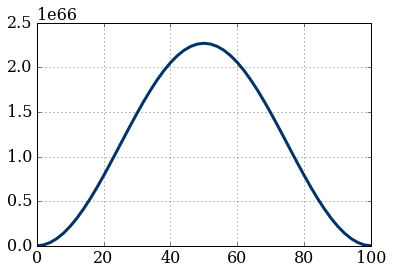

In [104]:
pyplot.plot(x, probfunc_real, color='#003366', ls='-', lw=3);
pyplot.grid(True)


In [41]:
def psi_analytical(x, t, n_max, h, m, L, hbar):
    
    psi = 0
    for n in range (1, n_max+1):
        
        E = ((n**2)*(h**2))/(8*m*(L**2))
        
        summation = numpy.sqrt(2/L)*numpy.sin(n*numpy.pi*x/L)*numpy.exp(-1j*E*t/hbar)
        psi+= summation
        
    return psi


In [42]:
psi_analytical = psi_analytical(x, dt*nt, 1, h, m, L, hbar)
#print(psi_analytical)

#print(psi_analytical.real)

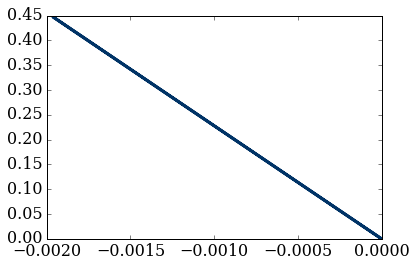

In [43]:
pyplot.plot(psi_analytical.imag, psi_analytical.real, color = '#003366', ls = '-', lw =3)

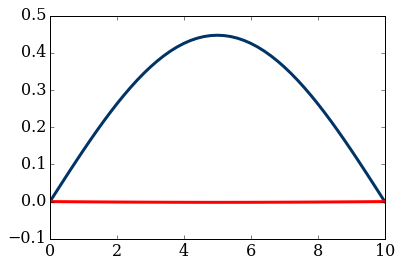

In [44]:
pyplot.plot(x, psi_analytical.real, color = '#003366', ls = '-', lw =3)
pyplot.plot(x, psi_analytical.imag, color = 'r', ls = '-', lw =3)

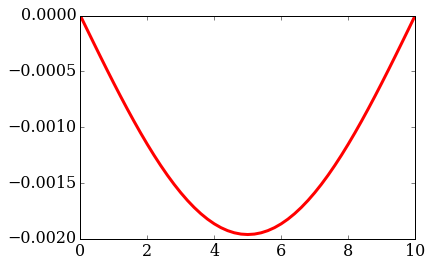

In [45]:
pyplot.plot(x, psi_analytical.imag, color = 'r', ls = '-', lw =3)

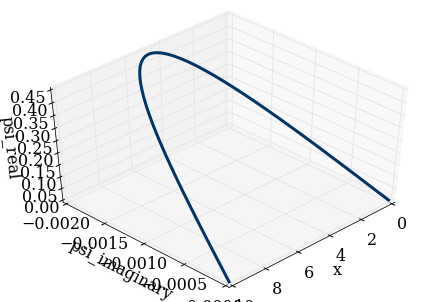

In [46]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.view_init(45,45)

ax.plot(x, psi_analytical.imag, psi_analytical.real, color = '#003366', lw =3)
ax.set_xlabel(r'x')
ax.set_ylabel(r'psi_imaginary')
ax.set_zlabel(r'psi_real')
#ax = pyplot.axes(xlabel=('x'),ylabel=('Real'), zlabel=('Imaginary'));#

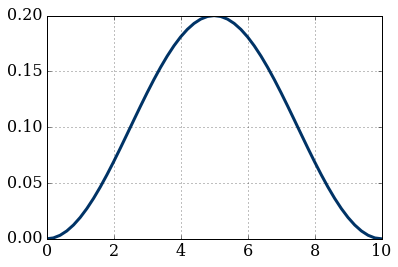

In [47]:
probfunc_analytical = numpy.conj(psi_analytical)*psi_analytical
pyplot.plot(x, probfunc_analytical.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)

In [48]:
"""
fig = pylab.figure()
ax = Axes3D(fig)
ax.viewinit()

def animate(data):
    x = numpy.linspace(0, L, nx)
    y = data
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames = psi.real, interval = 50)

display_animation(anim, default_mode = 'once')
"""

"\nfig = pylab.figure()\nax = Axes3D(fig)\nax.viewinit()\n\ndef animate(data):\n    x = numpy.linspace(0, L, nx)\n    y = data\n    line.set_data(x, y)\n    return line,\n\nanim = animation.FuncAnimation(fig, animate, frames = psi.real, interval = 50)\n\ndisplay_animation(anim, default_mode = 'once')\n"